In [1]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Save an IBM Quantum account and set it as your default account.
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="3938ec2167453e68ce3646104524ba97ba6ac764a519f4d27ae60605457a2573c9c1ae623c61938e759da0b428b13897be8a891a6740628557d539870d873c48")
 
# Load saved credentials
# service = QiskitRuntimeService()

service = QiskitRuntimeService(channel="ibm_quantum", token="20087d51312815e73fc41da774aae12d7fc0cb5560cbf289e0a4e34ded4072d4050be4137820956956a33e80c0b9b13c0ce3d7d74d2d34777e92230420695103")

# 3938ec2167453e68ce3646104524ba97ba6ac764a519f4d27ae60605457a2573c9c1ae623c61938e759da0b428b13897be8a891a6740628557d539870d873c48
 

In [4]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

In [5]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'

## Step 1: Map classical inputs to a quantum problem

In [6]:
# hamiltonian = SparsePauliOp.from_list(
#     [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
# )

hamiltonian = SparsePauliOp.from_list(
                [("IIII", -0.0996), 
                ("IIIZ", 0.1711), 
                ("IIZI", 0.1711), 
                ("IZII", -0.2225), 
                ("ZIII", -0.2225), 
                ("IIZZ", 0.1686), 
                ("IZIZ", 0.1205), 
                ("ZIIZ", 0.1658), 
                ("IZZI", 0.1658), 
                ("ZIZI", 0.1205), 
                ("ZZII", 0.1743), 
                ("XYYX", 0.0453), 
                ("YXXY", 0.0453), 
                ("YYXX", -0.0453), 
                ("XXYY", -0.0453)]
            )

# hamiltonian = SparsePauliOp.from_list(
#     [("IIII", -0.81054), 
#      ("IZIZ", 0.16614), 
#      ("ZIZI", 0.16892), 
#      ("ZIII", 0.17218), 
#      ("IIZI", 0.17218), 
#      ("IZII", -0.22573), 
#      ("IIIZ", -0.22573), 
#      ("ZZII", 0.12091), 
#      ("IIZZ", 0.12091), 
#      ("ZIIZ", 0.166145), 
#      ("IZZI", 0.166145), 
#      ("YYYY", 0.04523), 
#      ("XXYY", 0.04523), 
#      ("YYXX", 0.04523), 
#      ("XXXX", 0.04523)]
# )

In [7]:
hamiltonian

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII', 'XYYX', 'YXXY', 'YYXX', 'XXYY'],
              coeffs=[-0.0996+0.j,  0.1711+0.j,  0.1711+0.j, -0.2225+0.j, -0.2225+0.j,
  0.1686+0.j,  0.1205+0.j,  0.1658+0.j,  0.1658+0.j,  0.1205+0.j,
  0.1743+0.j,  0.0453+0.j,  0.0453+0.j, -0.0453+0.j, -0.0453+0.j])

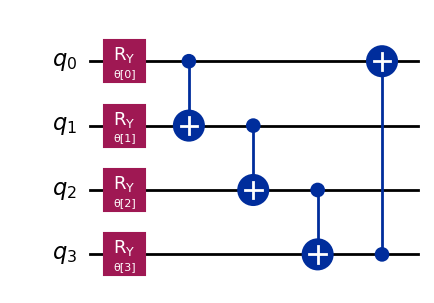

In [8]:
from qiskit.circuit.library import TwoLocal

entangler_map = [[0, 1], [1, 2], [2,3], [3,0]]  # entangle the first and last two-way
ansatz = TwoLocal(hamiltonian.num_qubits, 'ry', 'cx', entangler_map, reps=1, skip_final_rotation_layer=True)

ansatz.decompose().draw("mpl", style="iqp")

In [9]:
num_params = ansatz.num_parameters
num_params

4

## Step 2: Optimize problem for quantum execution.

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

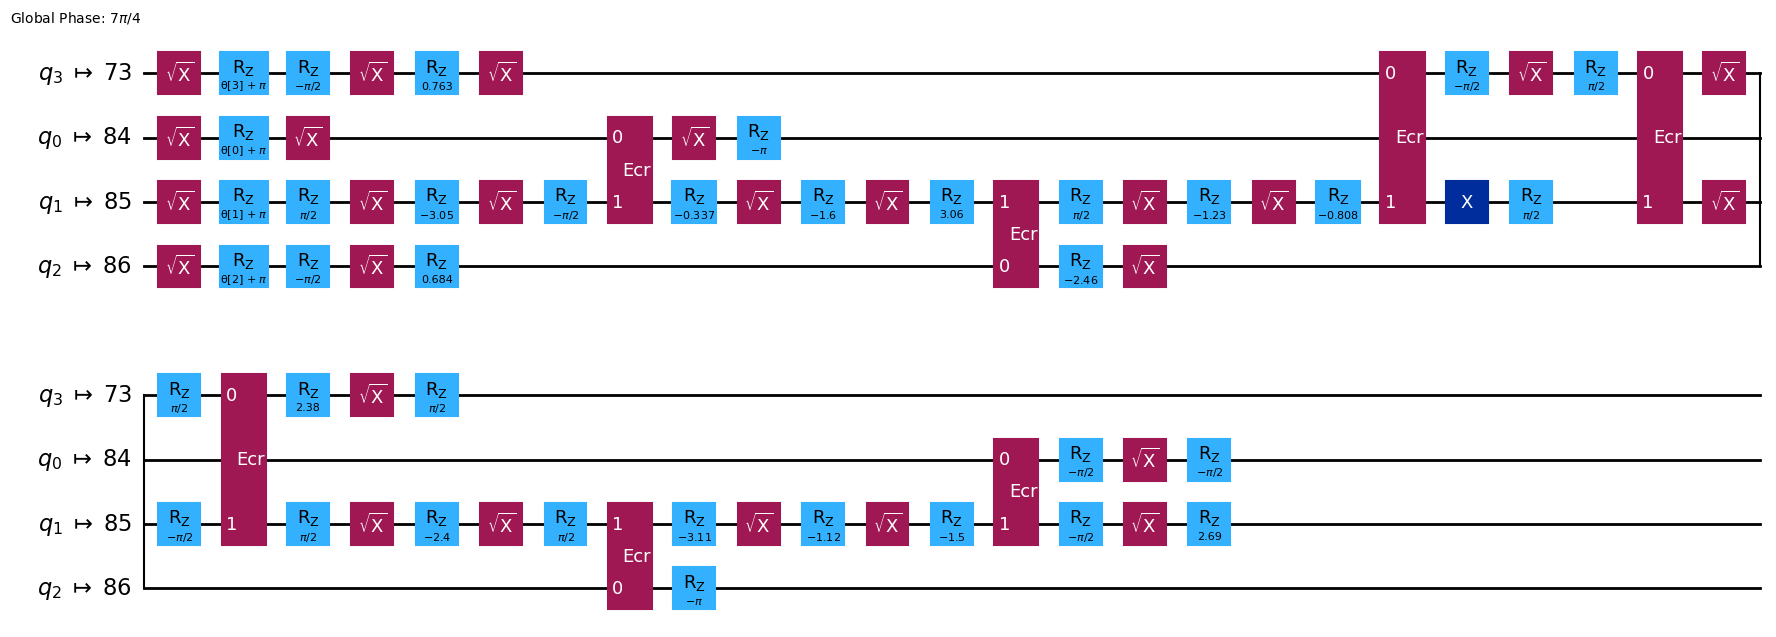

In [11]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [12]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## Step 3: Execute using Qiskit Primitives.

### COBYLA Optimizer

In [13]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [14]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([4.4410364 , 5.29449068, 0.25977458, 4.34352131])

In [73]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 200

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method='cobyla',
    )

Iters. done: 1 [Current cost: -0.40750772007942027]
Iters. done: 2 [Current cost: -0.40430386680852415]
Iters. done: 3 [Current cost: -0.38115599153815927]
Iters. done: 4 [Current cost: -0.40140428743583334]
Iters. done: 5 [Current cost: -0.43910528637460716]
Iters. done: 6 [Current cost: -0.29432232255917784]
Iters. done: 7 [Current cost: -0.41153977039817746]
Iters. done: 8 [Current cost: -0.4091438192283841]
Iters. done: 9 [Current cost: -0.41787588225456346]
Iters. done: 10 [Current cost: -0.4142119003044943]
Iters. done: 11 [Current cost: -0.3890838738741376]
Iters. done: 12 [Current cost: -0.38363826705241044]
Iters. done: 13 [Current cost: -0.42978630621227165]
Iters. done: 14 [Current cost: -0.4388331215003457]
Iters. done: 15 [Current cost: -0.4332310898139571]
Iters. done: 16 [Current cost: -0.3955273611119217]
Iters. done: 17 [Current cost: -0.41887298047505983]
Iters. done: 18 [Current cost: -0.4140174915747389]
Iters. done: 19 [Current cost: -0.4088439827664784]
Iters. don

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [15]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 2048

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method='cobyla',
    )

KeyboardInterrupt: 

### Nakanishi Fuji Todo Optimizer

In [16]:
from nftopt import nakanishi_fujii_todo

with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 200

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method=nakanishi_fujii_todo,
    )

Iters. done: 1 [Current cost: -0.03304209157425797]
Iters. done: 2 [Current cost: 0.1270447231867413]
Iters. done: 3 [Current cost: -0.16035246850576618]
Iters. done: 4 [Current cost: -0.19930409865419968]
Iters. done: 5 [Current cost: -0.09937222957842345]
Iters. done: 6 [Current cost: -0.4439270327180427]
Iters. done: 7 [Current cost: -0.31038269211696035]
Iters. done: 8 [Current cost: -0.8026734106894123]
Iters. done: 9 [Current cost: -0.4755137482877023]
Iters. done: 10 [Current cost: -0.3175135960683815]
Iters. done: 11 [Current cost: -0.15659685746758256]
Iters. done: 12 [Current cost: 0.057164696139886534]
Iters. done: 13 [Current cost: -0.5904735623651911]
Iters. done: 14 [Current cost: -0.32495668334868855]
Iters. done: 15 [Current cost: -0.22196290728853083]
Iters. done: 16 [Current cost: -0.6973949237768546]
Iters. done: 17 [Current cost: -0.7211719105464421]
Iters. done: 18 [Current cost: -0.28439532468771245]
Iters. done: 19 [Current cost: -0.3910192817425649]
Iters. done:

IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

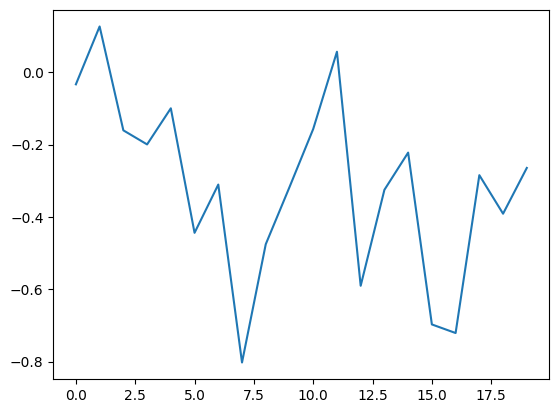

In [17]:
cost_history_dict
plt.plot(cost_history_dict['cost_history'])


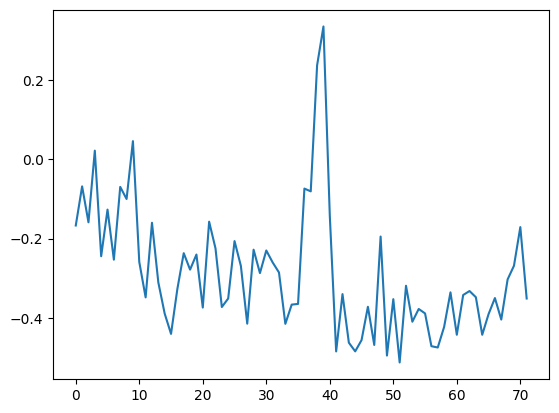

In [ ]:
cost_history_dict
plt.plot(cost_history_dict['cost_history'])

In [ ]:
!pip install nftopt

## Step 4: Post-process, return result in classical format.

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

In [ ]:
cost_history_dict["iters"] == res.nfev

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
cost_history_dict

{'prev_vector': array([3.05888996, 4.43727613, 5.39903657, 5.66676143, 3.91592233,
        4.00972591, 4.42010001, 2.20419641, 1.54907842, 4.74382172,
        1.6739801 , 4.65247405, 5.86036756, 4.70397595, 0.87260049,
        1.27107314]),
 'iters': 20,
 'cost_history': [0.14922586116758643,
  -0.11612803571621408,
  0.07002776280206445,
  -0.13386988850633055,
  -0.3302387656462088,
  -0.10234731983003965,
  -0.13772207900026967,
  -0.45905039527309566,
  -0.445916509386791,
  -0.36337138067990404,
  -0.42997434693744946,
  -0.28915363465327376,
  -0.35322293062687277,
  -0.5704129149833769,
  -0.47988316089181043,
  -0.46759465876835415,
  -0.24320415638696258,
  -0.588662767522721,
  -0.44708847005466235,
  -0.5228542313152235]}

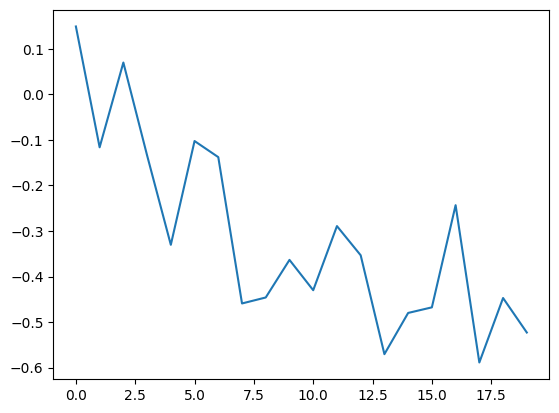

In [ ]:
plt.plot(cost_history_dict['cost_history'])